In [3]:
import pandas as pd
import numpy as np

In [4]:
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RandomizedSearchCV,GridSearchCV

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv("MSFT.csv",index_col=0)

df['Close'] = df['Adj Close']
df = df.drop("Adj Close",axis=1)



# Adding moving averages

In [7]:
for sma_period in [5,10,20,50,100,200]:
    indicator_name = "SMA_%d" % (sma_period)
    df[indicator_name] = df['Close'].rolling(sma_period).mean()

# Adding Bollinger bands

In [8]:
df['BollingerBand_Up_20_2'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()
df['BollingerBand_Down_20_2'] = df['Close'].rolling(20).mean() - 2*df['Close'].rolling(20).std()


df['BollingerBand_Up_20_1'] = df['Close'].rolling(20).mean() + df['Close'].rolling(20).std()
df['BollingerBand_Down_20_1'] = df['Close'].rolling(20).mean() - df['Close'].rolling(20).std()

df['BollingerBand_Up_10_1'] = df['Close'].rolling(10).mean() + df['Close'].rolling(10).std()
df['BollingerBand_Down_10_1'] = df['Close'].rolling(10).mean() - df['Close'].rolling(10).std()

df['BollingerBand_Up_10_2'] = df['Close'].rolling(10).mean() + 2*df['Close'].rolling(10).std()
df['BollingerBand_Down_10_2'] = df['Close'].rolling(10).mean() - 2*df['Close'].rolling(10).std()


# Adding Donchian channels

In [9]:
for channel_period in [5,10,20,50,100,200]:
    up_name = "Donchian_Channel_Up_%d" % (channel_period)
    down_name = "Donchian_Channel_Down_%d" % (channel_period)
    
    df[up_name] = df['High'].rolling(channel_period).max()
    df[down_name] = df['Low'].rolling(channel_period).min()

# Creating input features

In [10]:
newdata = df['Close'].to_frame()
for lag in [1,2,3,4,5,6,7,8,9,10]:
    shift = lag
    shifted = df.shift(shift)
    shifted.columns = [str.format("%s_shifted_by_%d" % (column ,shift)) for column in shifted.columns]
    newdata = pd.concat((newdata,shifted),axis=1)



# Creating target variable

In [11]:
forward_lag = 5

newdata['target'] = newdata['Close'].shift(-forward_lag)
newdata = newdata.drop('Close',axis=1)

newdata = newdata.dropna()


In [12]:
newdata

,Open_shifted_by_1,High_shifted_by_1,Low_shifted_by_1,Close_shifted_by_1,Volume_shifted_by_1,SMA_5_shifted_by_1,SMA_10_shifted_by_1,SMA_20_shifted_by_1,SMA_50_shifted_by_1,SMA_100_shifted_by_1,...,Donchian_Channel_Down_10_shifted_by_10,Donchian_Channel_Up_20_shifted_by_10,Donchian_Channel_Down_20_shifted_by_10,Donchian_Channel_Up_50_shifted_by_10,Donchian_Channel_Down_50_shifted_by_10,Donchian_Channel_Up_100_shifted_by_10,Donchian_Channel_Down_100_shifted_by_10,Donchian_Channel_Up_200_shifted_by_10,Donchian_Channel_Down_200_shifted_by_10,target
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-21,27.950001,27.990000,27.680000,22.284258,52811000.0,22.303493,22.031048,21.385597,21.000577,20.299382,...,24.930000,27.129999,24.930000,28.870001,23.780001,28.870001,23.320000,31.580000,22.730000,22.412468
2010-12-22,27.850000,28.139999,27.760000,22.492596,38153000.0,22.375610,22.127204,21.479349,21.058754,20.319845,...,24.930000,27.240000,24.930000,28.870001,23.780001,28.870001,23.320000,31.580000,22.730000,22.316315
2010-12-23,28.010000,28.400000,27.980000,22.588747,42252300.0,22.430096,22.204128,21.602349,21.115031,20.337151,...,24.930000,27.340000,24.930000,28.870001,23.780001,28.870001,23.320000,31.580000,22.730000,22.364389
2010-12-27,27.969999,28.320000,27.959999,22.676893,24902500.0,22.479775,22.301887,21.719740,21.164949,20.356684,...,24.930000,27.400000,24.930000,28.870001,23.780001,28.870001,23.320000,31.580000,22.730000,22.420481
2010-12-28,28.120001,28.200001,27.879999,22.492596,21652800.0,22.507018,22.360382,21.832724,21.212932,20.377781,...,25.000000,27.450001,24.930000,28.870001,23.780001,28.870001,23.320000,31.580000,22.730000,22.508627
2010-12-29,27.969999,28.170000,27.959999,22.444517,23042200.0,22.539070,22.421281,21.940899,21.255016,20.401249,...,25.559999,27.750000,24.930000,28.870001,23.910000,28.870001,23.320000,31.580000,22.730000,22.436506
2010-12-30,27.940001,28.120001,27.879999,22.412468,19502500.0,22.523044,22.449327,22.049476,21.291999,20.422970,...,26.200001,27.990000,24.930000,28.870001,24.129999,28.870001,23.320000,31.580000,22.730000,23.093576
2010-12-31,27.920000,28.000000,27.780001,22.316315,20786100.0,22.468558,22.449327,22.121994,21.338527,20.443255,...,26.760000,27.990000,24.930000,28.870001,24.280001,28.870001,23.320000,31.580000,22.730000,22.917286
2011-01-03,27.799999,27.920000,27.629999,22.364389,24752000.0,22.406057,22.442916,22.162861,21.382672,20.468298,...,26.760000,28.090000,24.930000,28.870001,24.370001,28.870001,23.320000,31.580000,22.730000,22.612789


# Training and test set

In [13]:
X = newdata.drop("target",axis=1)
Y = newdata['target']

train_size = int(X.shape[0]*0.7)

X_train = X[0:train_size]
y_train = Y[0:train_size]

X_test = X[train_size:]
y_test = Y[train_size:]



# Feature selection via Pearson correlation coeffficient

In [14]:
correlations = np.abs(X_train.corrwith(y_train))

features =  list(correlations.sort_values(ascending=False)[0:50].index)


In [15]:
print(features)

['Close_shifted_by_1', 'SMA_5_shifted_by_1', 'Close_shifted_by_2', 'SMA_5_shifted_by_2', 'SMA_10_shifted_by_1', 'Close_shifted_by_3', 'SMA_5_shifted_by_3', 'BollingerBand_Up_10_1_shifted_by_1', 'High_shifted_by_1', 'Low_shifted_by_1', 'BollingerBand_Down_10_1_shifted_by_1', 'Close_shifted_by_4', 'SMA_10_shifted_by_2', 'Open_shifted_by_1', 'SMA_5_shifted_by_4', 'BollingerBand_Up_10_1_shifted_by_2', 'Close_shifted_by_5', 'High_shifted_by_2', 'SMA_10_shifted_by_3', 'BollingerBand_Down_10_1_shifted_by_2', 'Low_shifted_by_2', 'Donchian_Channel_Up_5_shifted_by_1', 'Donchian_Channel_Down_5_shifted_by_1', 'Open_shifted_by_2', 'BollingerBand_Up_10_1_shifted_by_3', 'SMA_5_shifted_by_5', 'Close_shifted_by_6', 'SMA_10_shifted_by_4', 'High_shifted_by_3', 'BollingerBand_Up_10_2_shifted_by_1', 'BollingerBand_Down_10_1_shifted_by_3', 'BollingerBand_Up_20_1_shifted_by_1', 'Low_shifted_by_3', 'SMA_20_shifted_by_1', 'Donchian_Channel_Up_5_shifted_by_2', 'BollingerBand_Up_10_1_shifted_by_4', 'Open_shifted

In [16]:
X_train = X_train[features]
X_test = X_test[features]

# Linear regression

In [35]:
lr = LinearRegression()

lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [36]:
y_pred = lr.predict(X_test)

In [37]:
mean_absolute_error(y_test,y_pred)

2.3790133963688107

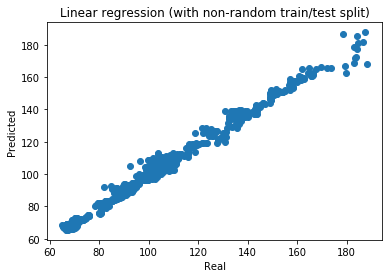

In [38]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear regression (with non-random train/test split)")
plt.show()

# Random forest

In [40]:
rf = RandomizedSearchCV(RandomForestRegressor(),param_distributions =  {
                                'n_estimators':np.arange(10,500,5),
                                'max_features':np.arange(1,10,1)
                            },
                            cv=5, n_iter = 20,
                            iid=False,random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

rf.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': array([ 10,  15, ..., 490, 495]), 'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [41]:
rf.best_params_

{'n_estimators': 165, 'max_features': 1}

In [42]:
y_pred = rf.predict(X_test)

In [43]:
mean_absolute_error(y_test,y_pred)

42.591489728491936

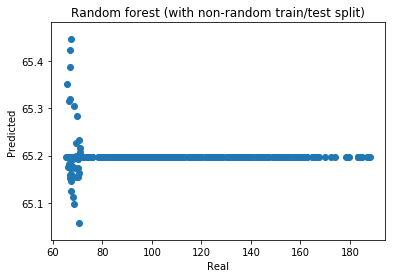

In [44]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Random forest (with non-random train/test split)")
plt.show()

# Gradient boosting regressor

In [45]:
gb = RandomizedSearchCV(GradientBoostingRegressor(),param_distributions =  {
                                'n_estimators':np.arange(10,500,5),
                                'max_features':np.arange(1,10,1)
                            },
                            cv=5, n_iter = 20,
                            iid=False,random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

gb.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': array([ 10,  15, ..., 490, 495]), 'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [46]:
gb.best_params_

{'n_estimators': 85, 'max_features': 8}

In [47]:
y_pred = gb.predict(X_test)

In [48]:
mean_absolute_error(y_test,y_pred)

42.59364527460274

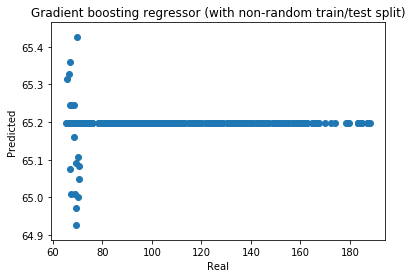

In [49]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Gradient boosting regressor (with non-random train/test split)")
plt.show()

# K Nearest Neighbors

In [50]:
knn = GridSearchCV(KNeighborsRegressor(),param_grid =  {
                                'n_neighbors':np.arange(1,20,1),
                                'weights':['distance','uniform']
                            },
                            cv=5, 
                            iid=False,refit=True,
                            scoring="neg_mean_absolute_error")

knn.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]), 'weights': ['distance', 'uniform']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [51]:
knn.best_params_

{'n_neighbors': 19, 'weights': 'distance'}

In [52]:
y_pred = knn.predict(X_test)

In [53]:
mean_absolute_error(y_test,y_pred)

42.88512566808827

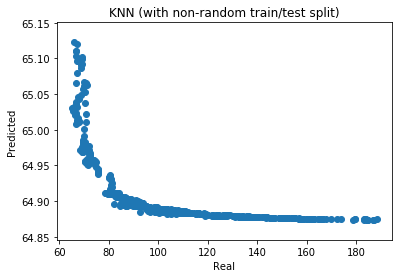

In [54]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("KNN (with non-random train/test split)")
plt.show()

# Neural network

In [17]:
scaler = MinMaxScaler()

scaler.fit(X_train)


nnet = RandomizedSearchCV(MLPRegressor(max_iter=5000,learning_rate = 'adaptive',solver='sgd'),param_distributions =  {
                                'hidden_layer_sizes':[(x,) for x in np.arange(1,50,1)],
                                'activation':['logistic','relu']
                            },
                            cv=5, n_iter = 20,
                            iid=False,random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

In [18]:
nnet.fit(scaler.transform(X_train),y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
          fit_params=None, iid=False, n_iter=20, n_jobs=None,
          param_distributions={'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,)], 'activation': ['

In [19]:
y_pred = nnet.predict(scaler.transform(X_test))

In [20]:
nnet.best_params_

{'hidden_layer_sizes': (30,), 'activation': 'relu'}

In [21]:
mean_absolute_error(y_test,y_pred)

2.366558231491265

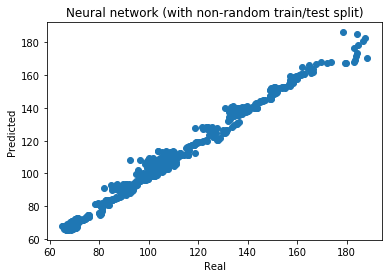

In [22]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Neural network (with non-random train/test split)")
plt.show()

# Linear regression with bagging

In [23]:
lr_bag = RandomizedSearchCV(BaggingRegressor(LinearRegression()),param_distributions =  {
                                'n_estimators':np.arange(10,500,5),
                                'max_features':np.arange(1,10,1)
                            },
                            cv=5, n_iter = 20,
                            iid=False,random_state=0,refit=True,
                            scoring="neg_mean_absolute_error")

lr_bag.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=BaggingRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=20, n_jobs=None,
          param_distributions={'n_estimators': array([ 10,  15, ..., 490, 495]), 'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=0)

In [24]:
y_pred = lr_bag.predict(X_test)

In [25]:
lr_bag.best_params_

{'n_estimators': 255, 'max_features': 9}

In [26]:
mean_absolute_error(y_test,y_pred)

2.3430176509354252

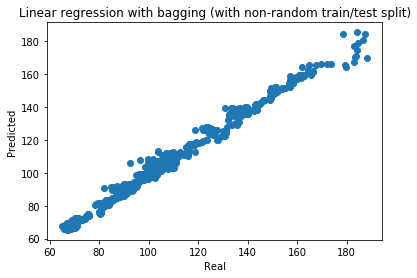

In [27]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear regression with bagging (with non-random train/test split)")
plt.show()

# Linear regression with boosting

In [28]:
lr_boost = GridSearchCV(AdaBoostRegressor(LinearRegression()),param_grid =  {
                                'n_estimators':np.arange(20,500,5)
                            },
                            cv=5, 
                            iid=False,refit=True,
                            scoring="neg_mean_absolute_error")

lr_boost.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
         learning_rate=1.0, loss='linear', n_estimators=50,
         random_state=None),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'n_estimators': array([ 20,  25, ..., 490, 495])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [29]:
y_pred = lr_boost.predict(X_test)

In [30]:
lr_boost.best_params_

{'n_estimators': 210}

In [31]:
mean_absolute_error(y_test,y_pred)

2.5801580730606894

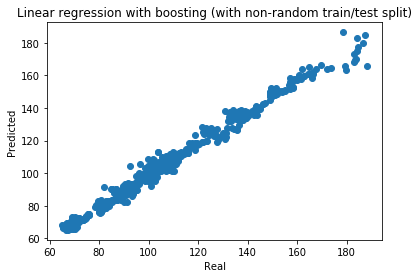

In [32]:
plt.scatter(y_test,y_pred)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Linear regression with boosting (with non-random train/test split)")
plt.show()